In [18]:
"""
Create a Spark Session

"""

from pyspark.sql import SparkSession
import pyarrow.parquet as pq
spark = (
    SparkSession.builder.appName("MAST30034 Assignment")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

In [19]:
"""
Open the parquet file we just saved

"""

from pyspark.sql.functions import col, month, hour, to_date, dayofweek

# data cleansing for yellow taxi 
data = spark.read.parquet("data/curated/curated_yellow_taxi_visualisation.parquet")
data.show()

+------------+------------+----+----------+-----------+
|PULocationID|total_amount|hour|      date|day of week|
+------------+------------+----+----------+-----------+
|          48|        12.3|   0|2019-02-01|          6|
|         230|        33.3|   0|2019-02-01|          6|
|          95|         6.8|   0|2019-02-01|          6|
|         140|         6.3|   0|2019-02-01|          6|
|         229|         5.8|   0|2019-02-01|          6|
|          75|         6.3|   0|2019-02-01|          6|
|         246|        15.3|   0|2019-02-01|          6|
|          79|        11.8|   0|2019-02-01|          6|
|         170|         7.0|  23|2019-01-31|          5|
|         107|       11.62|  23|2019-01-31|          5|
|         107|       10.56|  23|2019-01-31|          5|
|          68|       12.35|   0|2019-02-01|          6|
|         246|         8.8|   0|2019-02-01|          6|
|         161|         5.8|   0|2019-02-01|          6|
|         161|       24.75|  23|2019-01-31|     

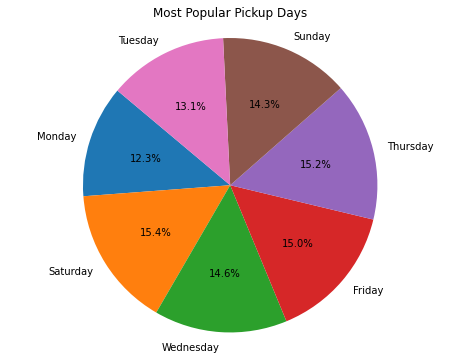

In [20]:
"""
Visualize the best day to do trip for yellow taxi drivers by plotting pie chart and show the most popular pick up day among week

"""
import pandas as pd 
from pyspark.sql.functions import col, sum, count, when
from pyspark.sql import Row
import matplotlib.pyplot as plt

grouped_df = data.groupBy("day of week").count().alias("trips_per_day")
grouped_df = grouped_df.withColumn("day of week", 
                                    when(col("day of week") == 1, "Monday")
                                    .when(col("day of week") == 2, "Tuesday")
                                    .when(col("day of week") == 3, "Wednesday")
                                    .when(col("day of week") == 4, "Thursday")
                                    .when(col("day of week") == 5, "Friday")
                                    .when(col("day of week") == 6, "Saturday")
                                    .otherwise("Sunday")
                                    )

grouped_df = grouped_df.toPandas()

# plot a pie chart
plt.figure(figsize=(8, 6))
plt.pie(grouped_df["count"], labels=grouped_df["day of week"], autopct="%1.1f%%", startangle=140)
plt.title("Most Popular Pickup Days")
plt.axis("equal") 
plt.show()

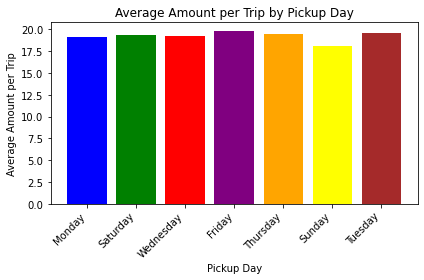

In [21]:
"""
Plot the bar chart to show (pickup/revenue) per day among week for yellow taxi

"""


grouped_df2 = data.groupBy("day of week").agg(
    sum(col("total_amount")).alias("total_amount_per_day"),
    count("*").alias("trips_per_day")
)

# find average amount per trip 
avg_grouped_df = grouped_df2.withColumn("avg_amount_per_trip",
                                           col("total_amount_per_day") / col("trips_per_day"))

average_grouped_df = avg_grouped_df.withColumn("day of week", 
                                    when(col("day of week") == 1, "Monday")
                                    .when(col("day of week") == 2, "Tuesday")
                                    .when(col("day of week") == 3, "Wednesday")
                                    .when(col("day of week") == 4, "Thursday")
                                    .when(col("day of week") == 5, "Friday")
                                    .when(col("day of week") == 6, "Saturday")
                                    .otherwise("Sunday")
                                    )

avg_data = average_grouped_df.select("day of week", "avg_amount_per_trip").collect()


x_values = [row["day of week"] for row in avg_data]
y_values = [row.avg_amount_per_trip for row in avg_data]

colors = ['blue', 'green', 'red', 'purple', 'orange', 'yellow', 'brown']

# plot the bar chart 
plt.bar(x_values, y_values, color = colors)
plt.xlabel('Pickup Day')
plt.ylabel('Average Amount per Trip')
plt.title('Average Amount per Trip by Pickup Day')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()

plt.show()



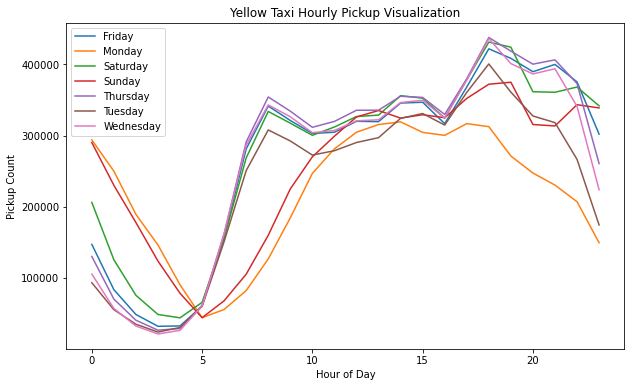

In [22]:
"""
Plot a 'days of week line graph' for yellow taxi hourly pick up visualization

"""

hourly_pickup_counts = data.groupBy("day of week","hour").agg(count("*").alias("pickup count"))
hourly_pickup_counts = hourly_pickup_counts.withColumn("day of week", 
                                    when(col("day of week") == 1, "Monday")
                                    .when(col("day of week") == 2, "Tuesday")
                                    .when(col("day of week") == 3, "Wednesday")
                                    .when(col("day of week") == 4, "Thursday")
                                    .when(col("day of week") == 5, "Friday")
                                    .when(col("day of week") == 6, "Saturday")
                                    .otherwise("Sunday")
                                    )
hourly_pickup_counts = hourly_pickup_counts.toPandas()
hourly_pickup_counts = hourly_pickup_counts.sort_values(by=['day of week', 'hour'])

# Plot a line graph 
fig, ax = plt.subplots(figsize=(10, 6))

for day, group in hourly_pickup_counts.groupby('day of week'):
    ax.plot(group['hour'], group['pickup count'], label=f'{day}')

# Add labels and title
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Pickup Count')
ax.set_title('Yellow Taxi Hourly Pickup Visualization')
ax.legend()

# Display the plot
plt.show()


In [26]:
data.show()

+------------+------------+----+----------+-----------+
|PULocationID|total_amount|hour|      date|day of week|
+------------+------------+----+----------+-----------+
|          48|        12.3|   0|2019-02-01|          6|
|         230|        33.3|   0|2019-02-01|          6|
|          95|         6.8|   0|2019-02-01|          6|
|         140|         6.3|   0|2019-02-01|          6|
|         229|         5.8|   0|2019-02-01|          6|
|          75|         6.3|   0|2019-02-01|          6|
|         246|        15.3|   0|2019-02-01|          6|
|          79|        11.8|   0|2019-02-01|          6|
|         170|         7.0|  23|2019-01-31|          5|
|         107|       11.62|  23|2019-01-31|          5|
|         107|       10.56|  23|2019-01-31|          5|
|          68|       12.35|   0|2019-02-01|          6|
|         246|         8.8|   0|2019-02-01|          6|
|         161|         5.8|   0|2019-02-01|          6|
|         161|       24.75|  23|2019-01-31|     

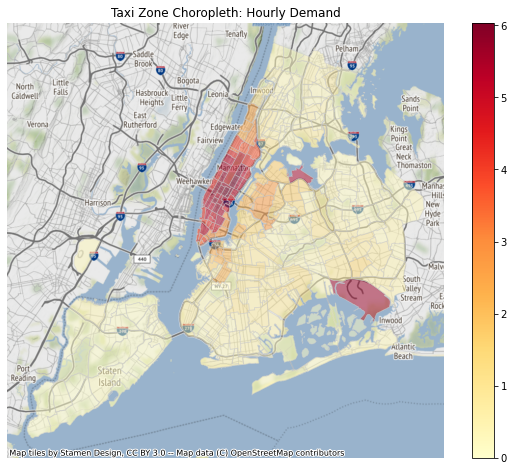

In [53]:
"""
Plot a heat map documenting average hourly demand per location

"""
import geopandas as gpd
import geodatasets
import contextily as cx
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, unix_timestamp
from pyspark.sql.functions import col, log

# imported from https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc
gdf = gpd.read_file("data/landing/taxi_zones.geojson")

# rename the location to match the index for the geo json file
yellow_taxi_full = data.withColumnRenamed("PULocationID", "location_id")

# find the average hourly demand per location
yellow_taxi_demand = yellow_taxi_full.groupBy("location_id", "date", "hour").count()
yellow_taxi_demand = yellow_taxi_demand.groupBy("location_id").avg("count")
yellow_taxi_demand = yellow_taxi_demand.withColumn("hourly demand", log(col("avg(count)")))

yellow_taxi_demand = yellow_taxi_demand.toPandas()
yellow_taxi_demand = dict(zip(yellow_taxi_demand['location_id'], yellow_taxi_demand['hourly demand']))

demand_data = {}
for i in range(1, 264):
    demand_data[str(i)] = 0

    if i in yellow_taxi_demand:
        demand_data[str(i)] = yellow_taxi_demand[i]

# Merge revenue data with GeoDataFrame
gdf["hourly demand"] = gdf["location_id"].map(demand_data)

# Plot choropleth
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

gdf_wm = gdf.to_crs(epsg=3857)
gdf_wm.plot(column="hourly demand", cmap="YlOrRd", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True, alpha=0.5)
cx.add_basemap(ax)

ax.set_title("Taxi Zone Choropleth: Hourly Demand")
ax.axis("off")
plt.show()


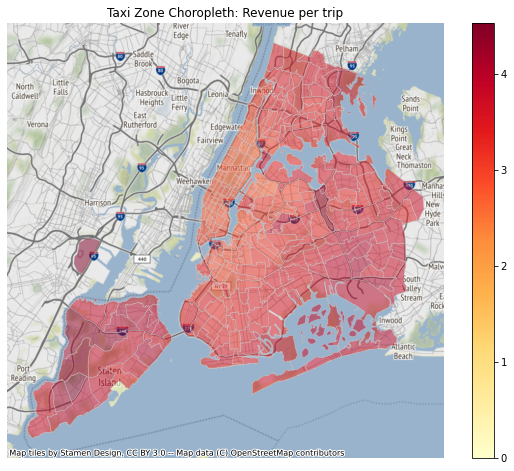

In [52]:
"""
Plot the average revenue per trip per location

"""
# imported from https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc
gdf = gpd.read_file("data/landing/taxi_zones.geojson")

yellow_taxi_revenue = yellow_taxi_full.groupBy("location_id").avg("total_amount")

#yellow_taxi_revenue = yellow_taxi_revenue.groupBy("location_id").avg("avg(total_amount)")
yellow_taxi_revenue = yellow_taxi_revenue.withColumn("revenue per trip", log(col("avg(total_amount)")))
yellow_taxi_revenue = yellow_taxi_revenue.toPandas()
yellow_taxi_revenue = dict(zip(yellow_taxi_revenue['location_id'], yellow_taxi_revenue['revenue per trip']))

revenue = {}
for i in range(1, 264):
    revenue[str(i)] = 0

    if i in yellow_taxi_revenue:
        revenue[str(i)] = yellow_taxi_revenue[i]

# Merge revenue data with GeoDataFrame
gdf["revenue per trip"] = gdf["location_id"].map(revenue)

# Plot choropleth
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

gdf_wm = gdf.to_crs(epsg=3857)
gdf_wm.plot(column="revenue per trip", cmap="YlOrRd", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True, alpha=0.5)
cx.add_basemap(ax)

ax.set_title("Taxi Zone Choropleth: Revenue per trip")
ax.axis("off")
plt.show()

